#Getting data in and formatting

##Massaging data

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import datetime
import matplotlib.pyplot as plt
from itertools import cycle
%matplotlib inline
stations = pd.read_table('stations.tsv')
usage = pd.read_table('usage_2012.tsv')
weather = pd.read_table('daily_weather.tsv')


def change_seasons():
    weather.loc[weather["season_code"] == 1, "season_desc"] = 'Winter'
    weather.loc[weather["season_code"] == 2, "season_desc"] = 'Spring'
    weather.loc[weather["season_code"] == 3, "season_desc"] = 'Summer'
    weather.loc[weather["season_code"] == 4, "season_desc"] = 'Fall'


def convert_dates():
    for i in weather.index:
        weather.ix[i, 'date'] = datetime.datetime.strptime(
            str(weather.ix[i, 'date']), "%Y-%m-%d").date()


def add_months():
    for i in weather.index:
        weather.ix[i, 'month'] = weather.ix[i, 'date'].month


change_seasons()
convert_dates()
add_months()

#Step 1: Get User counts per day at each station

In [3]:
yr_perstation = DataFrame(usage['station_start'].value_counts())
yr_perstation.columns = ["yr_count"]
yr_perstation['day_count'] = yr_perstation['yr_count']//366
yr_perstation['station'] = yr_perstation.index

cstations = stations.merge(yr_perstation, how="inner", left_on="station", right_on="station")


#Step 2a

In [4]:
from sklearn.linear_model import LinearRegression
# Here we grap all variables that we expect to monotonically impact ridership; this excludes
# geographic clustering which should be addressed by a clustering type model
x = cstations.ix[:, 7:136]
y = cstations.ix[:, 137]

model = LinearRegression()
model.fit(x, y)


LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

##Predict from training data

In [5]:
predicted = model.predict(x)
actual = cstations.day_count

predicted = DataFrame(predicted)
actual = DataFrame(actual)

predicted.columns = ['predicted']
actual.columns = ['actual']


##Step 2b. PLOT!

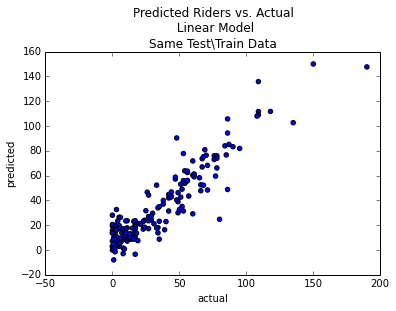

In [6]:
lindata = actual.join(predicted)
aplot = lindata.plot(x='actual', y='predicted', kind='scatter')
aplot.set_title("Predicted Riders vs. Actual\n Linear Model\nSame Test\Train Data")


As might be expected, the model is predicting the data it was trained on rather well (I think Joel called this 'cheating'). It seems to have more or less constant error throughout with rather good performance in predicted high traffic stations, and pretty lousy performance for stations with ridership at and below 25 riders (if we were to crop a graph window at 25 riders on each axis

##Step 2c. Look for evidence of overtraining in coeffs

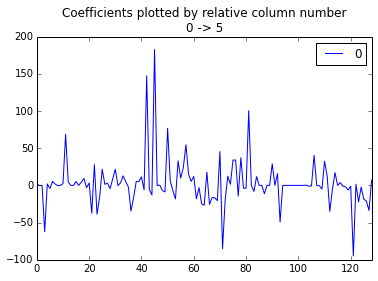

In [7]:
coeffs = model.coef_
coeffs = DataFrame(coeffs)
bplot = coeffs.plot()
bplot.set_title("Coefficients plotted by relative column number\n0 -> 5")

We can see that there are about 5 coeffs with coefficients > abs(50). 

In [8]:
#Getting a list of coeffs greater or less than 50
wonkyplus = coeffs[coeffs > 50].dropna()
wonkyminus = coeffs[coeffs < -50].dropna()
GOOD = [x.dtypes.index[i] for i in wonkyplus.index]
BAD = [x.dtypes.index[i] for i in wonkyminus.index]
print "These correlate with increasing ridership: {GOOD}\n\n"\
      "These correlate with decreasing ridership: {BAD}".format(GOOD=GOOD, BAD=BAD)


These correlate with increasing ridership: ['currency_exchange', 'clock', 'cultural_center', 'office', 'community_centre', 'bus_station']

These correlate with decreasing ridership: ['convenience', 'food_cart', 'hostel']


#Step 2d. Train and test with separated data

##Separating the data 

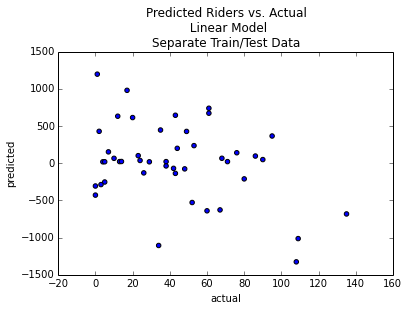

In [9]:
testd = cstations.copy()
traind = testd.sample(len(testd)/2)
testd = testd[~testd.isin(traind)].dropna()
# Asserting separation of these two dataframes; realize what is below doesn't look 'pythonic'
# but it works; 'is False' does not, because it is a Numpy bool type.
assert testd.isin(traind).all().all() == False

# Here we grap all variables that we expect to monotonically impact ridership; this excludes
# geographic clustering which should be addressed by a clustering type model
x1 = traind.ix[:, 5:136]
y1 = traind.ix[:, 137]

# This seems to be necessary; for whatever reason multiple instances of model are not
# independent from ewonkyplus = coeffs[coeffs > 50].dropna()
wonkyminus = coeffs[coeffs < -50].dropna()

del model 

model = LinearRegression()
model.fit(x1, y1)

x2 = testd.ix[:, 5:136]
y2 = testd.ix[:, 137]

predicted = model.predict(x2)
actual = testd.day_count

predicted = DataFrame(predicted)
actual = DataFrame(actual)

predicted.columns = ['predicted']
actual.columns = ['actual']

lindata = actual.join(predicted)
aplot = lindata.plot(x='actual', y='predicted', kind='scatter')
aplot.set_title("Predicted Riders vs. Actual\n Linear Model\nSeparate Train/Test Data")

Results are much worse now. Running the above code gives different results each time, and outliers are well off from actual expectations we should have from the data. It looks like we were "hashing" our data moreso than "describing" our data in the training data bit well above.

#Step 2a. Lasso our data to get the best vars

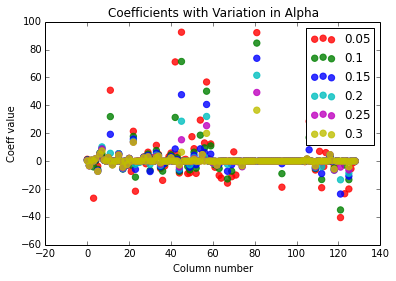

In [10]:
from sklearn.linear_model import Lasso

#alpha 0.05
del model
model = Lasso(alpha=0.05)
model.fit(x,y)
coeffs_0p05 = DataFrame(np.round(model.coef_, 1))

#alpha 0.10
del model
model = Lasso(alpha=0.10)
model.fit(x,y)
coeffs_0p10 = DataFrame(np.round(model.coef_, 1))

#alpha 0.15
del model
model = Lasso(alpha=0.15)
model.fit(x,y)
coeffs_0p15 = DataFrame(np.round(model.coef_, 1))

#alpha 0.20
del model
model = Lasso(alpha=0.20)
model.fit(x,y)
coeffs_0p20 = DataFrame(np.round(model.coef_, 1))

#alpha 0.25
del model
model = Lasso(alpha=0.25)
model.fit(x,y)
coeffs_0p25 = DataFrame(np.round(model.coef_, 1))

#alpha 0.30
del model
model = Lasso(alpha=0.30)
model.fit(x,y)
coeffs_0p30 = DataFrame(np.round(model.coef_, 1))

#alpha 0.35
del model
model = Lasso(alpha=0.35)
model.fit(x,y)
coeffs_0p35 = DataFrame(np.round(model.coef_, 1))

#alpha 0.40
del model
model = Lasso(alpha=0.40)
model.fit(x,y)
coeffs_0p40 = DataFrame(np.round(model.coef_, 1))

coeffls = [coeffs_0p05, coeffs_0p10, coeffs_0p15, coeffs_0p20,
           coeffs_0p25, coeffs_0p30]

colors = cycle(['r','g','b','c','m','y'])

alpha_st = 0.05

for df in coeffls:
    plt.scatter(df.index, df, color=next(colors), label=str(alpha_st), s=40, alpha=0.8)
    plt.legend()
    alpha_st += 0.05
    plt.title("Coefficients with Variation in Alpha")
    plt.ylabel("Coeff value")
    plt.xlabel("Column number")
    

Above we get a sense of how alpha impacts the overall footprint of our coeffiecients. Let's see which are still present (coeff > 1) for alpha at 0.40.

In [11]:
coeffs_query = coeffs_0p40[abs(coeffs_0p40) > 1].dropna()
query_cols = [x.dtypes.index[i] for i in coeffs_query.index]
print "Columns that survive lasso at 0.4 = alpha:\n\n{}".format(
    query_cols)

Columns that survive lasso at 0.4 = alpha:

['parking', 'post_office', 'bicycle_parking', 'drinking_water', 'recycling', 'cafe', 'fountain', 'pharmacy', 'car_sharing', 'bank', 'bar', 'embassy', 'place_of_worship', 'pub', 'public_building', 'school', 'theatre', 'tourist', 'community_centre', 'bench', 'check_cashing', 'bus_station', 'bus_stop', 'turning_circle', 'hotel', 'information']


###Going for even more restrictive Lasso

In [12]:
del model
model = Lasso(alpha=1.6)
model.fit(x,y)
coeffs_1p6 = DataFrame(np.round(model.coef_, 1))
coeffs_query = coeffs_1p6[abs(coeffs_1p6) > 1].dropna()
query_cols = [x.dtypes.index[i] for i in coeffs_query.index]
print "Columns that survive lasso at 1.6 = alpha:\n\n{}".format(
    query_cols)

Columns that survive lasso at 1.6 = alpha:

['parking', 'restaurant', 'bicycle_parking', 'drinking_water', 'cafe', 'bank', 'bar', 'embassy', 'place_of_worship', 'school', 'bench', 'hotel']


Note that crossings doesn't survive for reasons that we don't quite understand yet.

###How does this model perform on the test set?

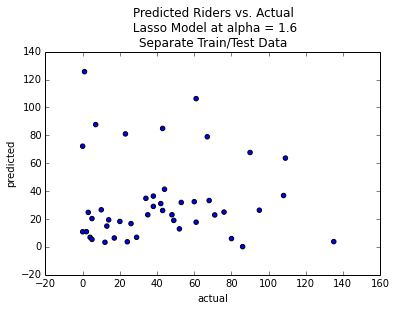

In [13]:
#x1/y1 are train data; x2/y2 are test data from above

del model 

model = Lasso(alpha=1.6)
model.fit(x1, y1)

predicted = model.predict(x2)
actual = testd.day_count

predicted = DataFrame(predicted)
actual = DataFrame(actual)

predicted.columns = ['predicted']
actual.columns = ['actual']

lindata = actual.join(predicted)
aplot = lindata.plot(x='actual', y='predicted', kind='scatter')
aplot.set_title("Predicted Riders vs. Actual\n Lasso Model at alpha = 1.6\nSeparate Train/Test Data")


Still pretty scatter-shot. Maybe marginally better than the full linear regression model.

##Step?? Just looking at the signals variable

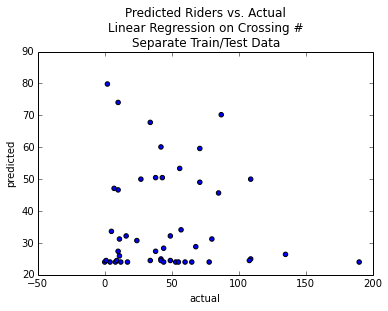

In [14]:
testd = cstations.copy()
traind = testd.sample(len(testd)/2)
testd = testd[~testd.isin(traind)].dropna()
# Asserting separation of these two dataframes; realize what is below doesn't look 'pythonic'
# but it works; 'is False' does not, because it is a Numpy bool type.
assert testd.isin(traind).all().all() == False

x1 = traind.crossing
y1 = traind.ix[:, 137]

del model 

model = LinearRegression()
model.fit(x1[:, np.newaxis], y1)

x2 = testd.crossing
y2 = testd.ix[:, 137]

predicted = model.predict(x2[:, np.newaxis])
actual = testd.day_count

predicted = DataFrame(predicted)
actual = DataFrame(actual)

predicted.columns = ['predicted']
actual.columns = ['actual']

lindata = actual.join(predicted)
aplot = lindata.plot(x='actual', y='predicted', kind='scatter')
aplot.set_title("Predicted Riders vs. Actual\nLinear Regression on Crossing #\nSeparate Train/Test Data")


Pretty rough. Doesn't seem to be as descriptive as the Lasso, but better than the LinearRegression model that includes all variables.